# Preprocessing Bias Mitigation Techniques

## Load Data

In [1]:
import sys
import os
# Add the root directory of the project to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('../../master-thesis-dizio-ay2324')))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
from matplotlib import rcParams

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from fairlib import DataFrame
from fairlib.preprocessing import DisparateImpactRemover
from fairlearn.metrics import (
    demographic_parity_ratio,
    equalized_odds_ratio,
    demographic_parity_difference,
    equalized_odds_difference
)

from utils.plot import plot_metrics, plot_metrics_grouped, get_mean_std

random_state = 42
np.random.seed(random_state)


/home/lyudmil/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
df_cleaned = pd.read_csv('cleaned_dataset.csv')

In [4]:
features = [
    # Base Attributes
    "Sex_int",
    "Protected category",
    "Overall",
    "Technical Skills",
    "Standing/Position",
    "Comunication",
    "Maturity",
    "Dynamism",
    "Mobility",
    "English",
    "Italian Residence",
    "European Residence",
    "Age Range_int",
    "number_of_searches",
    # Custom Similarity Scores
    "experience_match_score",
    "current_salary_fit_score",
    "expected_salary_fit_score",
    "study_title_score",
    "professional_similarity_score",
    "study_area_score",
    "general_similarity_score",
    "Distance Residence - Akkodis HQ",
    "Distance Residence - Assumption HQ",
]

In [5]:
protected_attributes = [
    'Sex_int', 'Protected category', 'Age Range_int',
    'Italian Residence', 'European Residence'
]

## Model

In [6]:
models = {
    'HistGradientBoosting': lambda: HistGradientBoostingClassifier(random_state=random_state),
    'XGBoost': lambda: XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=random_state, eval_metric='logloss', max_depth=6),
    'LightGBM': lambda: LGBMClassifier(class_weight='balanced', random_state=random_state, max_depth=6, min_data_in_leaf=20, verbosity=-1),
    'CatBoost': lambda: CatBoostClassifier(auto_class_weights='Balanced', silent=True, random_state=random_state, l2_leaf_reg=3, iterations=500, depth=6, learning_rate=0.05),
    'BalancedRF': lambda: BalancedRandomForestClassifier(random_state=random_state)
}

ensemble = lambda: VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']()),
        ('lgbm', models['LightGBM']()),
        ('cat', models['CatBoost']()),
        ('hist', models['HistGradientBoosting']()),
        ('brf', models['BalancedRF']())
    ],
    voting='soft'
)

## Disparate Impact Remover

In [7]:
results = defaultdict(list)

n_folds = 5
repair_levels = [0.0, 0.5, 1]  

dataset = pd.DataFrame(df_cleaned[features + ['Hired']])
bool_cols = dataset.select_dtypes(include='bool').columns
non_bool_cols = dataset[features].columns.difference(bool_cols)
dataset[bool_cols] = dataset[bool_cols].astype(int)

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in tqdm(enumerate(kf.split(dataset[features], dataset['Hired']))):
    X_train, X_test = dataset.iloc[train_idx][features], dataset.iloc[test_idx][features]
    y_train, y_test = dataset.iloc[train_idx]['Hired'], dataset.iloc[test_idx]['Hired']
    
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    
    scaler = StandardScaler()
    X_train[non_bool_cols] = scaler.fit_transform(X_train[non_bool_cols])
    X_test[non_bool_cols] = scaler.transform(X_test[non_bool_cols])
    
    for sensitive_attr in protected_attributes:
        for repair_level in repair_levels:
            dir = DisparateImpactRemover(repair_level=repair_level)
            
            X_train_df = pd.DataFrame(X_train).copy()
            X_train_df.sensitive = sensitive_attr
            X_test_df = pd.DataFrame(X_test).copy()
            X_test_df.sensitive = sensitive_attr
            
            X_train_repaired = dir.fit_transform(X_train_df)
            X_test_repaired = dir.fit_transform(X_test_df)
            
            clf = ensemble()
            clf.fit(X_train_repaired, y_train)
            y_pred = clf.predict(X_test_repaired)
            y_prob = clf.predict_proba(X_test_repaired)[:, 1]
            
            metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1': f1_score(y_test, y_pred, zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_prob),
                'demographic_parity_ratio': demographic_parity_ratio(
                    y_test, y_pred, sensitive_features=X_test_df[sensitive_attr]),
                'equalized_odds_ratio': equalized_odds_ratio(
                    y_test, y_pred, sensitive_features=X_test_df[sensitive_attr]),
                'demographic_parity_difference': demographic_parity_difference(
                    y_test, y_pred, sensitive_features=X_test_df[sensitive_attr]),
                'equalized_odds_difference': equalized_odds_difference(
                    y_test, y_pred, sensitive_features=X_test_df[sensitive_attr]),
            }

            key = f"{sensitive_attr}_repair_{repair_level}"
            results[key].append(metrics)

5it [05:17, 63.56s/it]


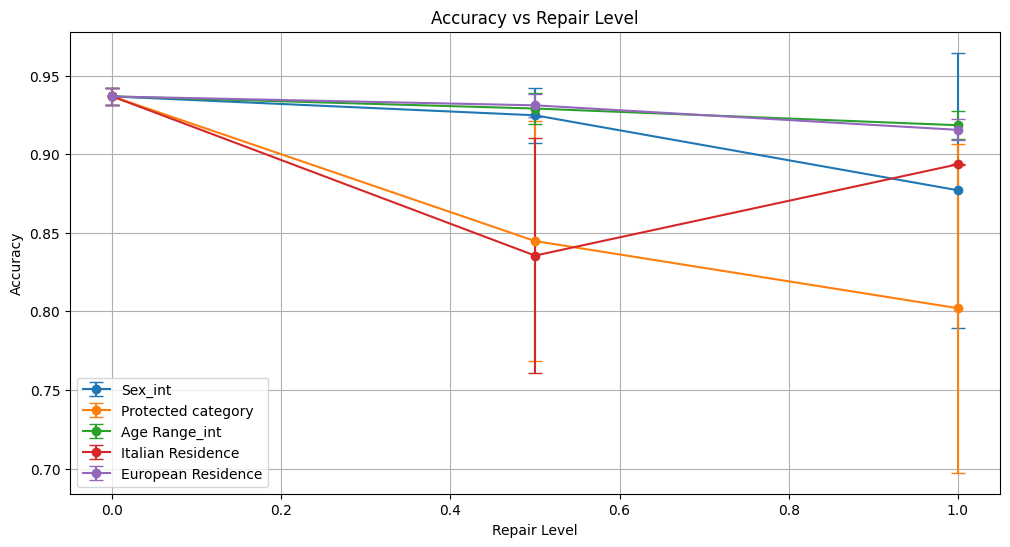

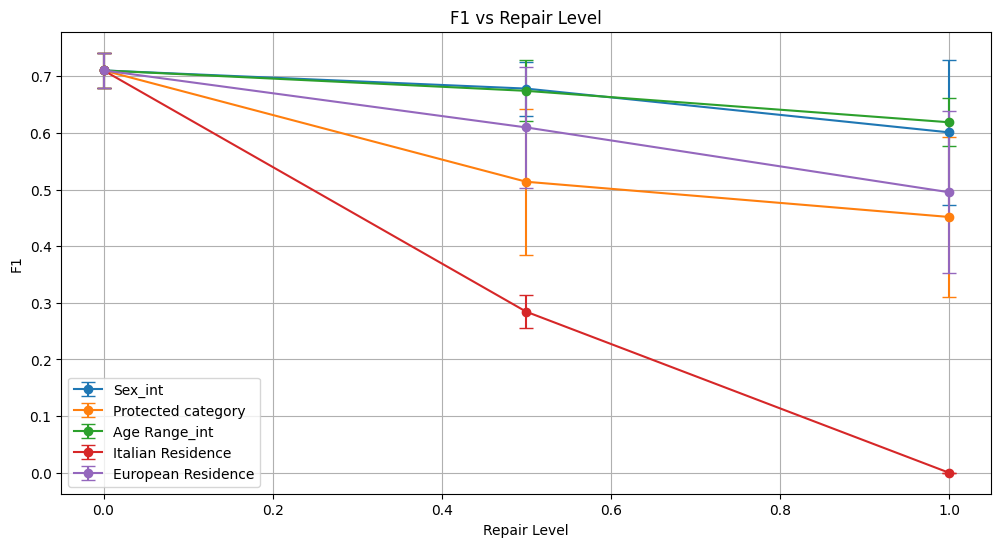

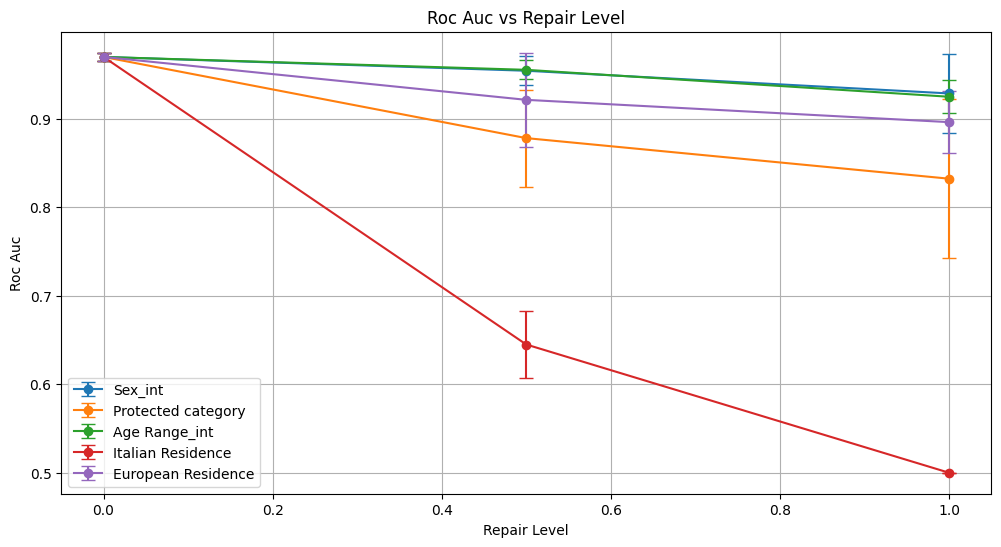

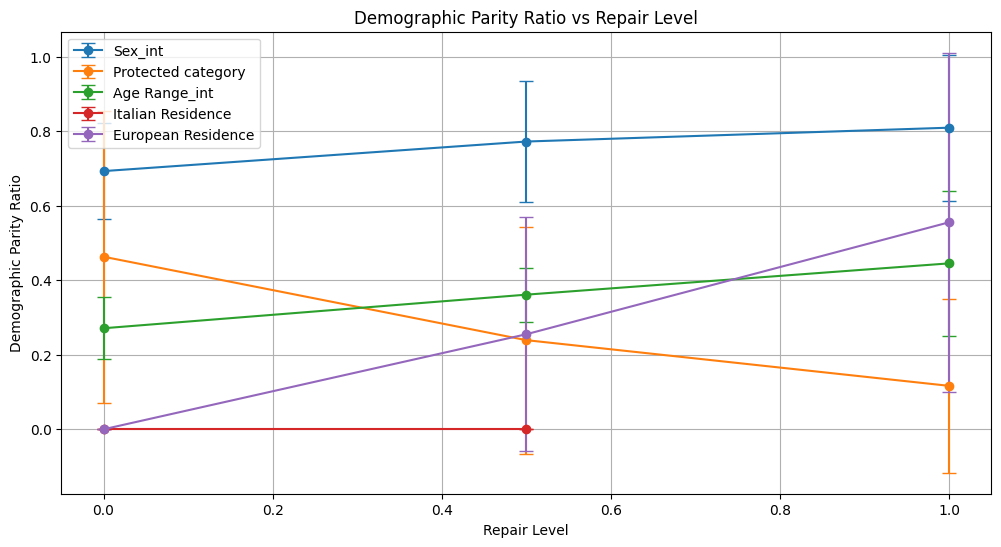

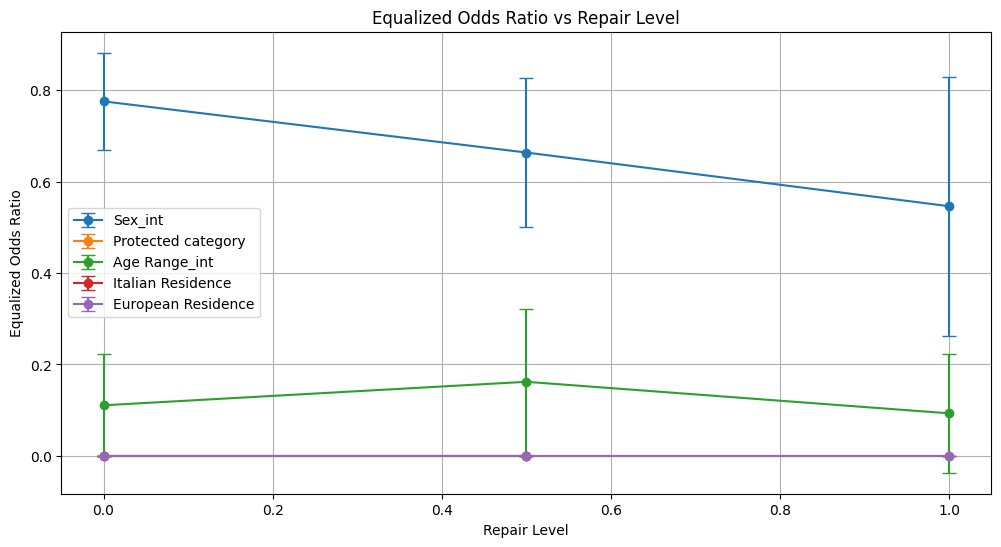


# Performance with Mitigation (mean ± std across folds)

## Protected Attribute: Sex_int

### Repair Level: 0.0
#### Performance Metrics:
- accuracy: 0.9367 ± 0.0055
- precision: 0.6926 ± 0.0261
- recall: 0.7325 ± 0.0608
- f1: 0.7104 ± 0.0313
- roc_auc: 0.9700 ± 0.0044

#### Fairness Metrics:
- demographic_parity_ratio: 0.6927 ± 0.1288
- equalized_odds_ratio: 0.7757 ± 0.1064
- demographic_parity_difference: 0.0481 ± 0.0214
- equalized_odds_difference: 0.0938 ± 0.0422

### Repair Level: 0.5
#### Performance Metrics:
- accuracy: 0.9247 ± 0.0173
- precision: 0.6367 ± 0.0762
- recall: 0.7368 ± 0.0601
- f1: 0.6783 ± 0.0475
- roc_auc: 0.9544 ± 0.0163

#### Fairness Metrics:
- demographic_parity_ratio: 0.7720 ± 0.1614
- equalized_odds_ratio: 0.6638 ± 0.1622
- demographic_parity_difference: 0.0366 ± 0.0259
- equalized_odds_difference: 0.1121 ± 0.0822

### Repair Level: 1
#### Performance Metrics:
- accuracy: 0.8771 ± 0.0875
- precision: 0.5314 ± 0.1559
- recall: 0.7389 ± 0.0432
- f1: 0.6010 ±

In [8]:
plot_data = defaultdict(dict)
for sensitive_attr in protected_attributes:
    for repair_level in repair_levels:
        key = f"{sensitive_attr}_repair_{repair_level}"
        for metric in ['accuracy', 'f1', 'roc_auc', 'demographic_parity_ratio', 'equalized_odds_ratio']:
            values = [m[metric] for m in results[key]]
            mean, std = get_mean_std(values)
            plot_data[sensitive_attr][f"{metric}_mean_{repair_level}"] = mean
            plot_data[sensitive_attr][f"{metric}_std_{repair_level}"] = std


for metric in ['accuracy', 'f1', 'roc_auc', 'demographic_parity_ratio', 'equalized_odds_ratio']:
    plot_metrics(plot_data, metric, repair_levels, protected_attributes)

print("\n# Performance with Mitigation (mean ± std across folds)")
for sensitive_attr in protected_attributes:
    print(f"\n## Protected Attribute: {sensitive_attr}")
    for repair_level in repair_levels:
        key = f"{sensitive_attr}_repair_{repair_level}"
        print(f"\n### Repair Level: {repair_level}")
        
        print("#### Performance Metrics:")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            mean, std = get_mean_std([m[metric] for m in results[key]])
            print(f"- {metric}: {mean:.4f} ± {std:.4f}")
        
        print("\n#### Fairness Metrics:")
        for metric in ['demographic_parity_ratio', 'equalized_odds_ratio',
                     'demographic_parity_difference', 'equalized_odds_difference']:
            mean, std = get_mean_std([m[metric] for m in results[key]])
            print(f"- {metric}: {mean:.4f} ± {std:.4f}")

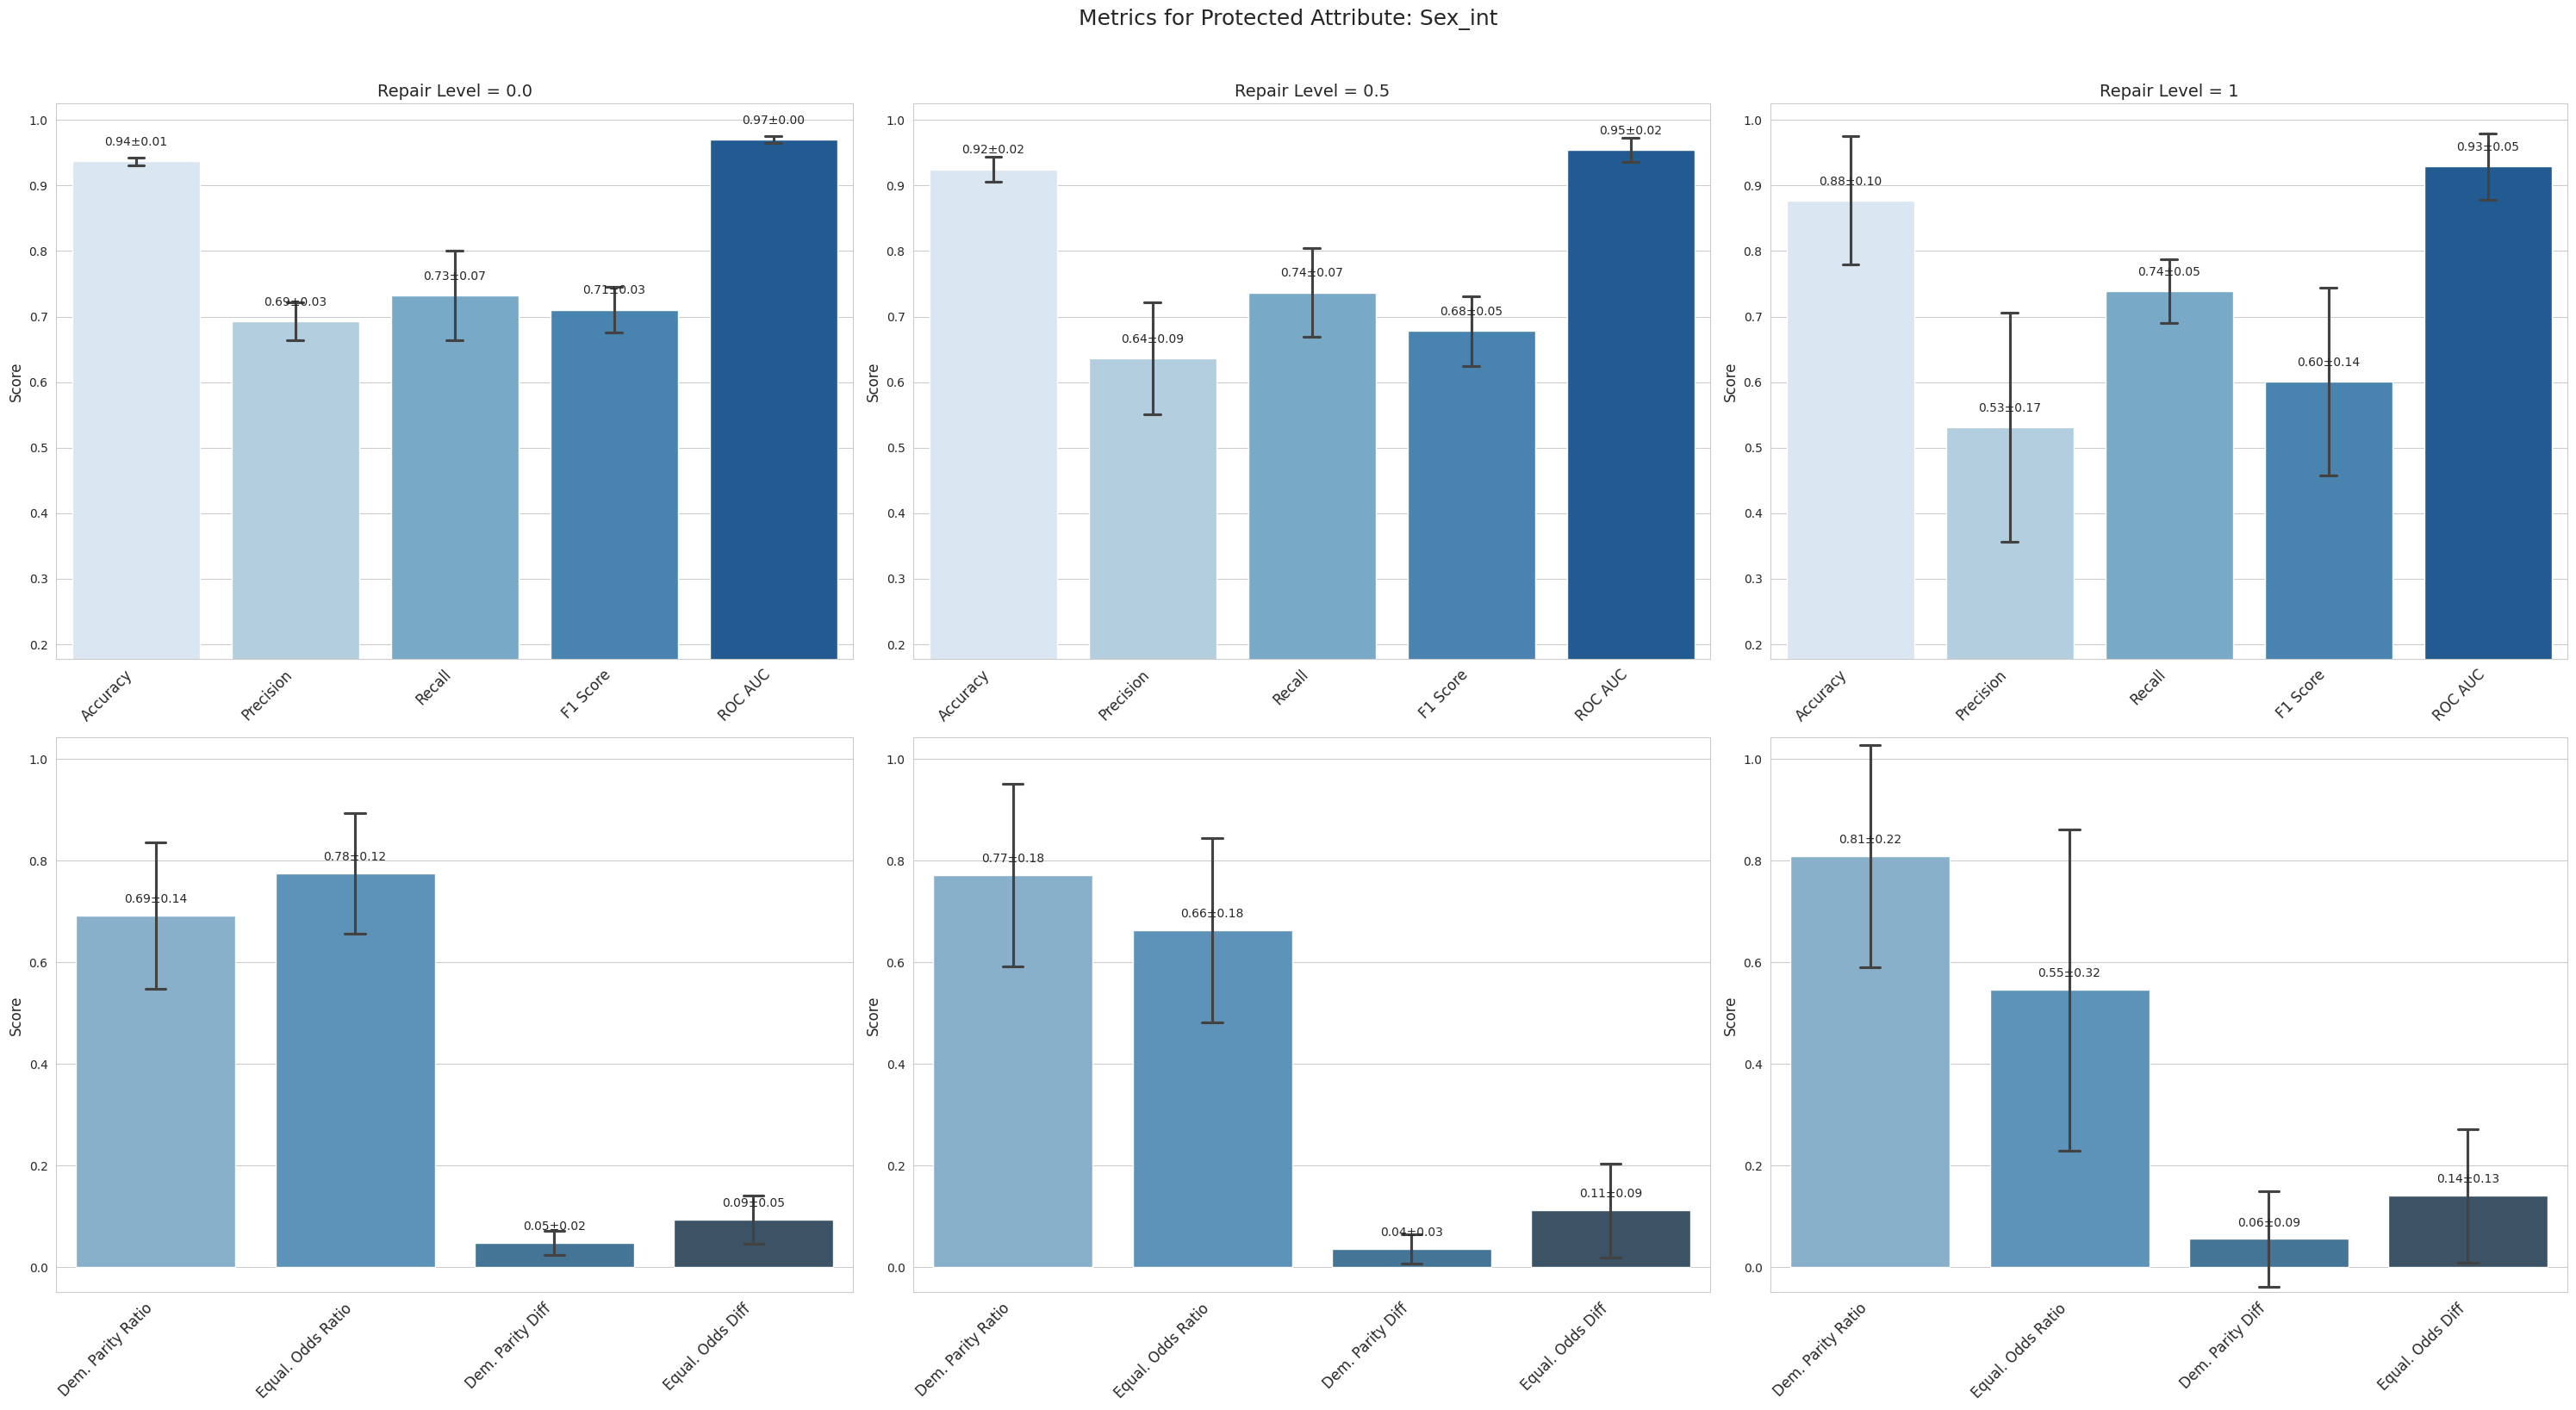

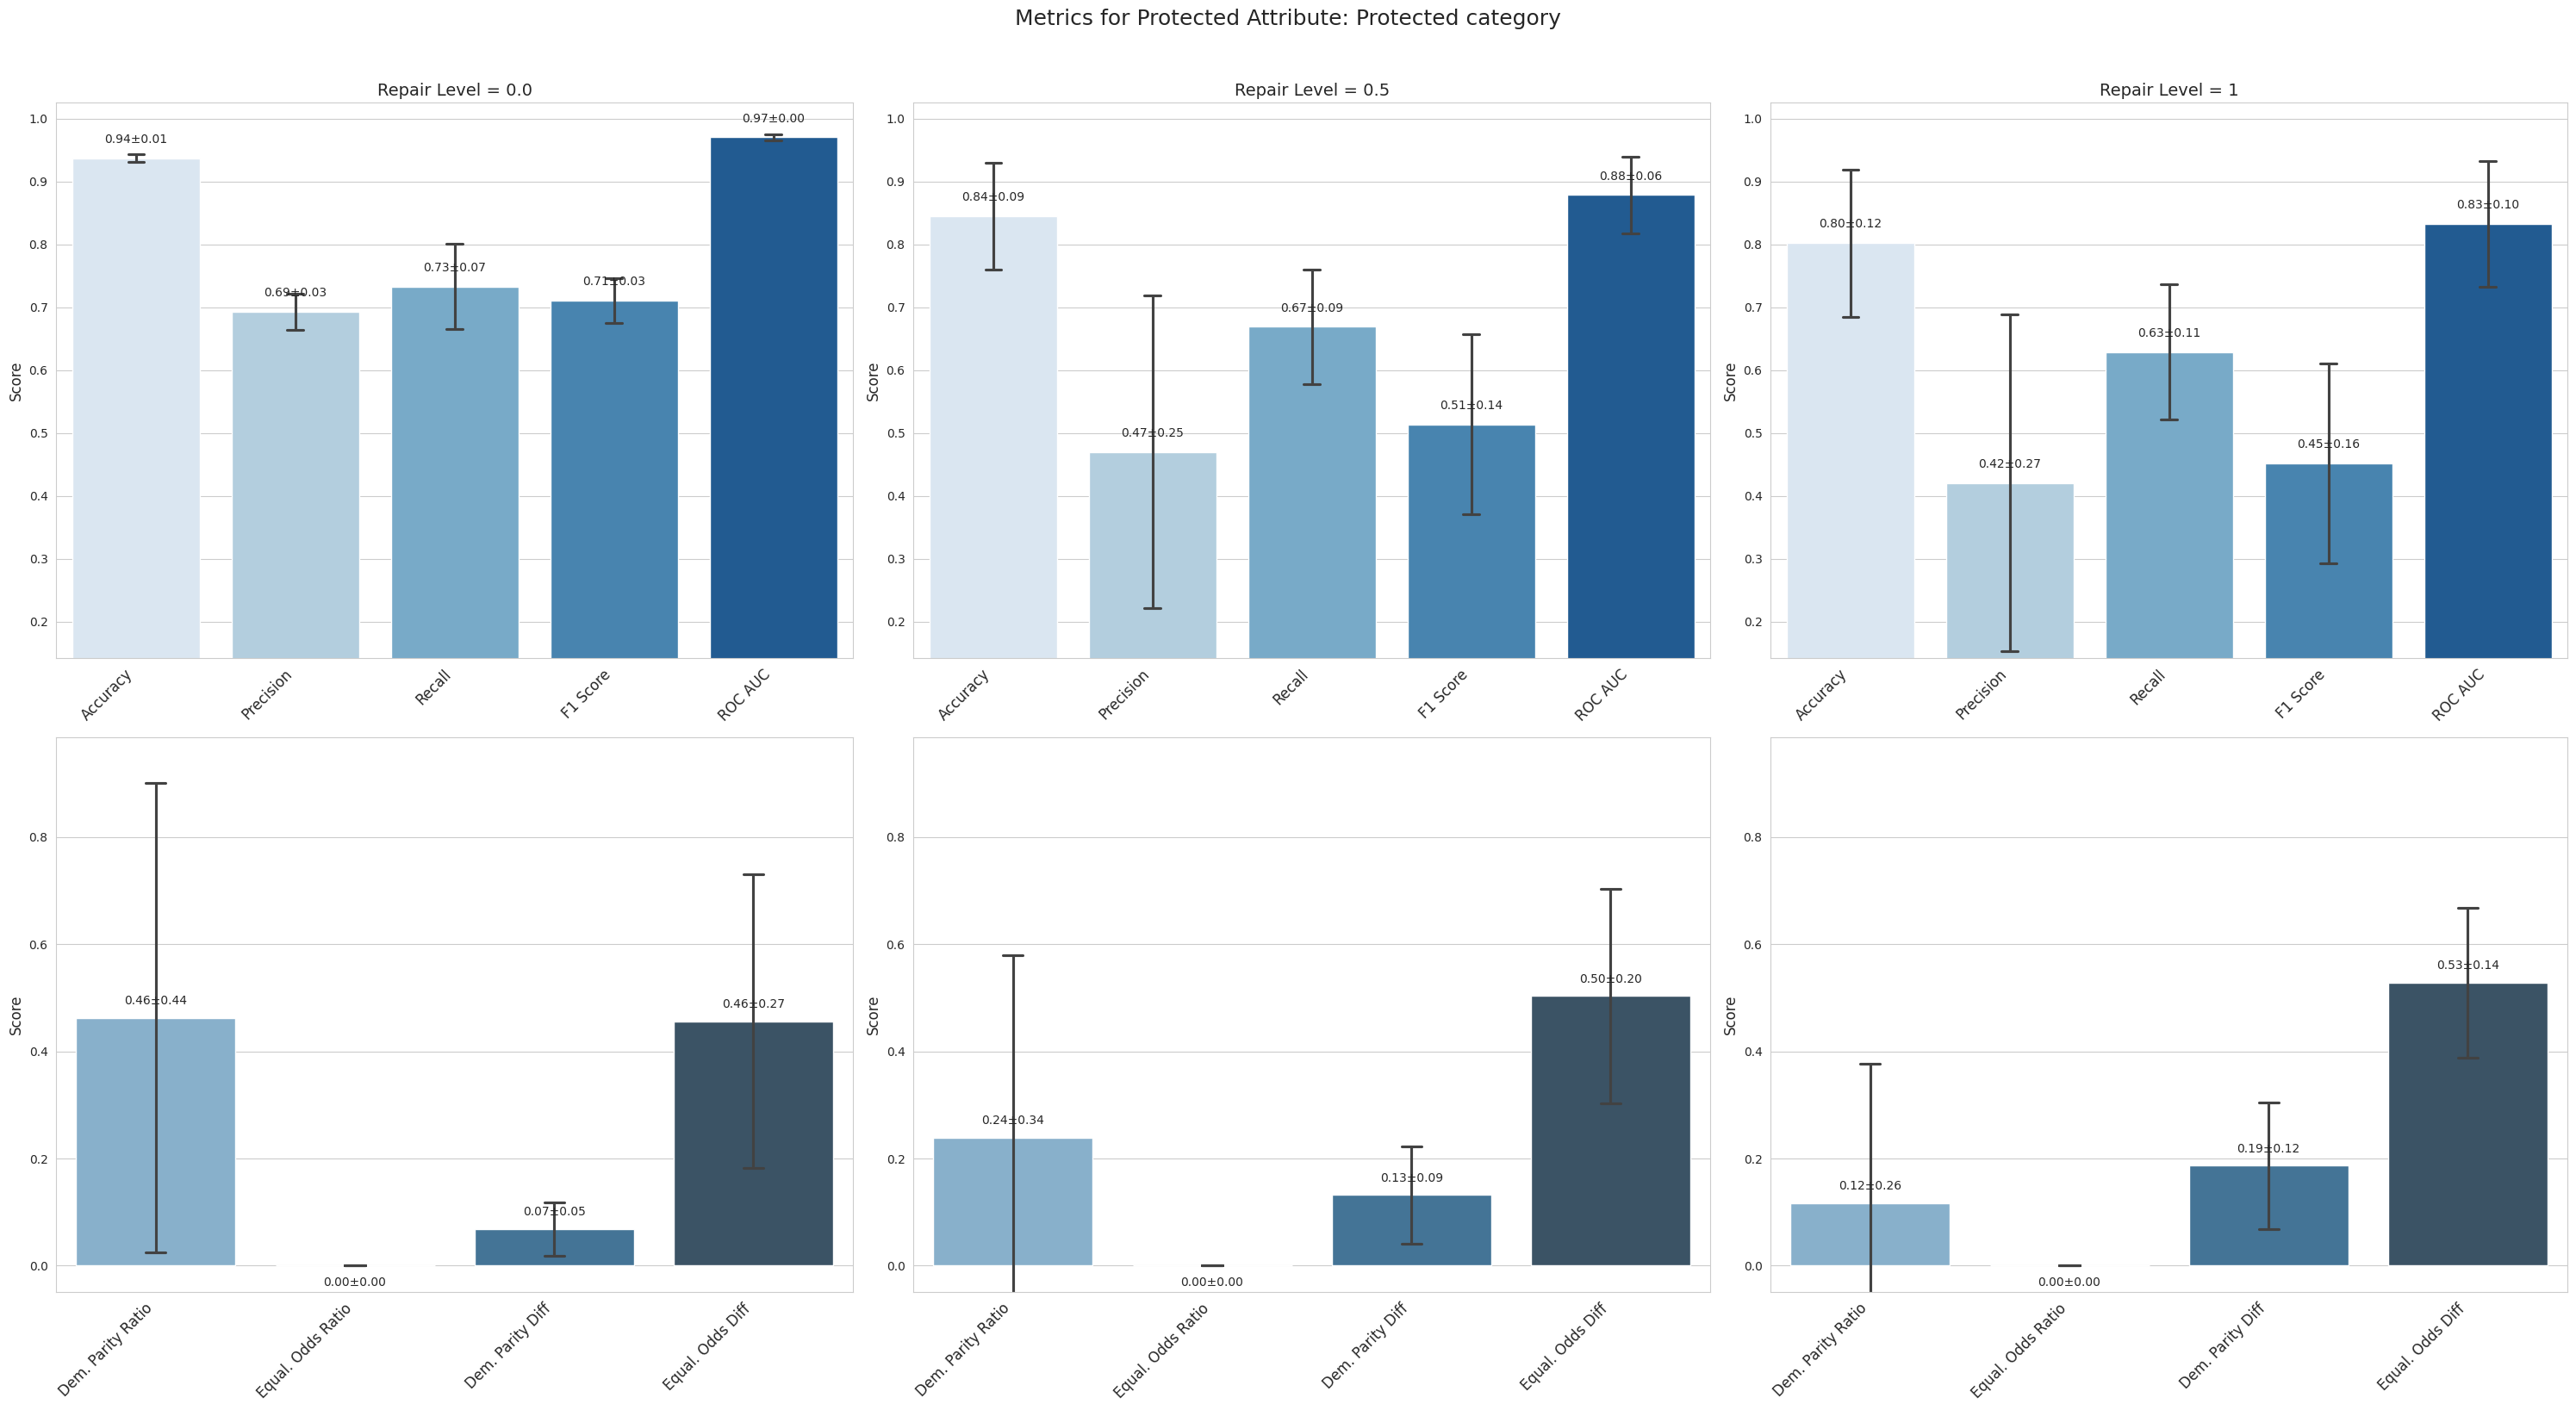

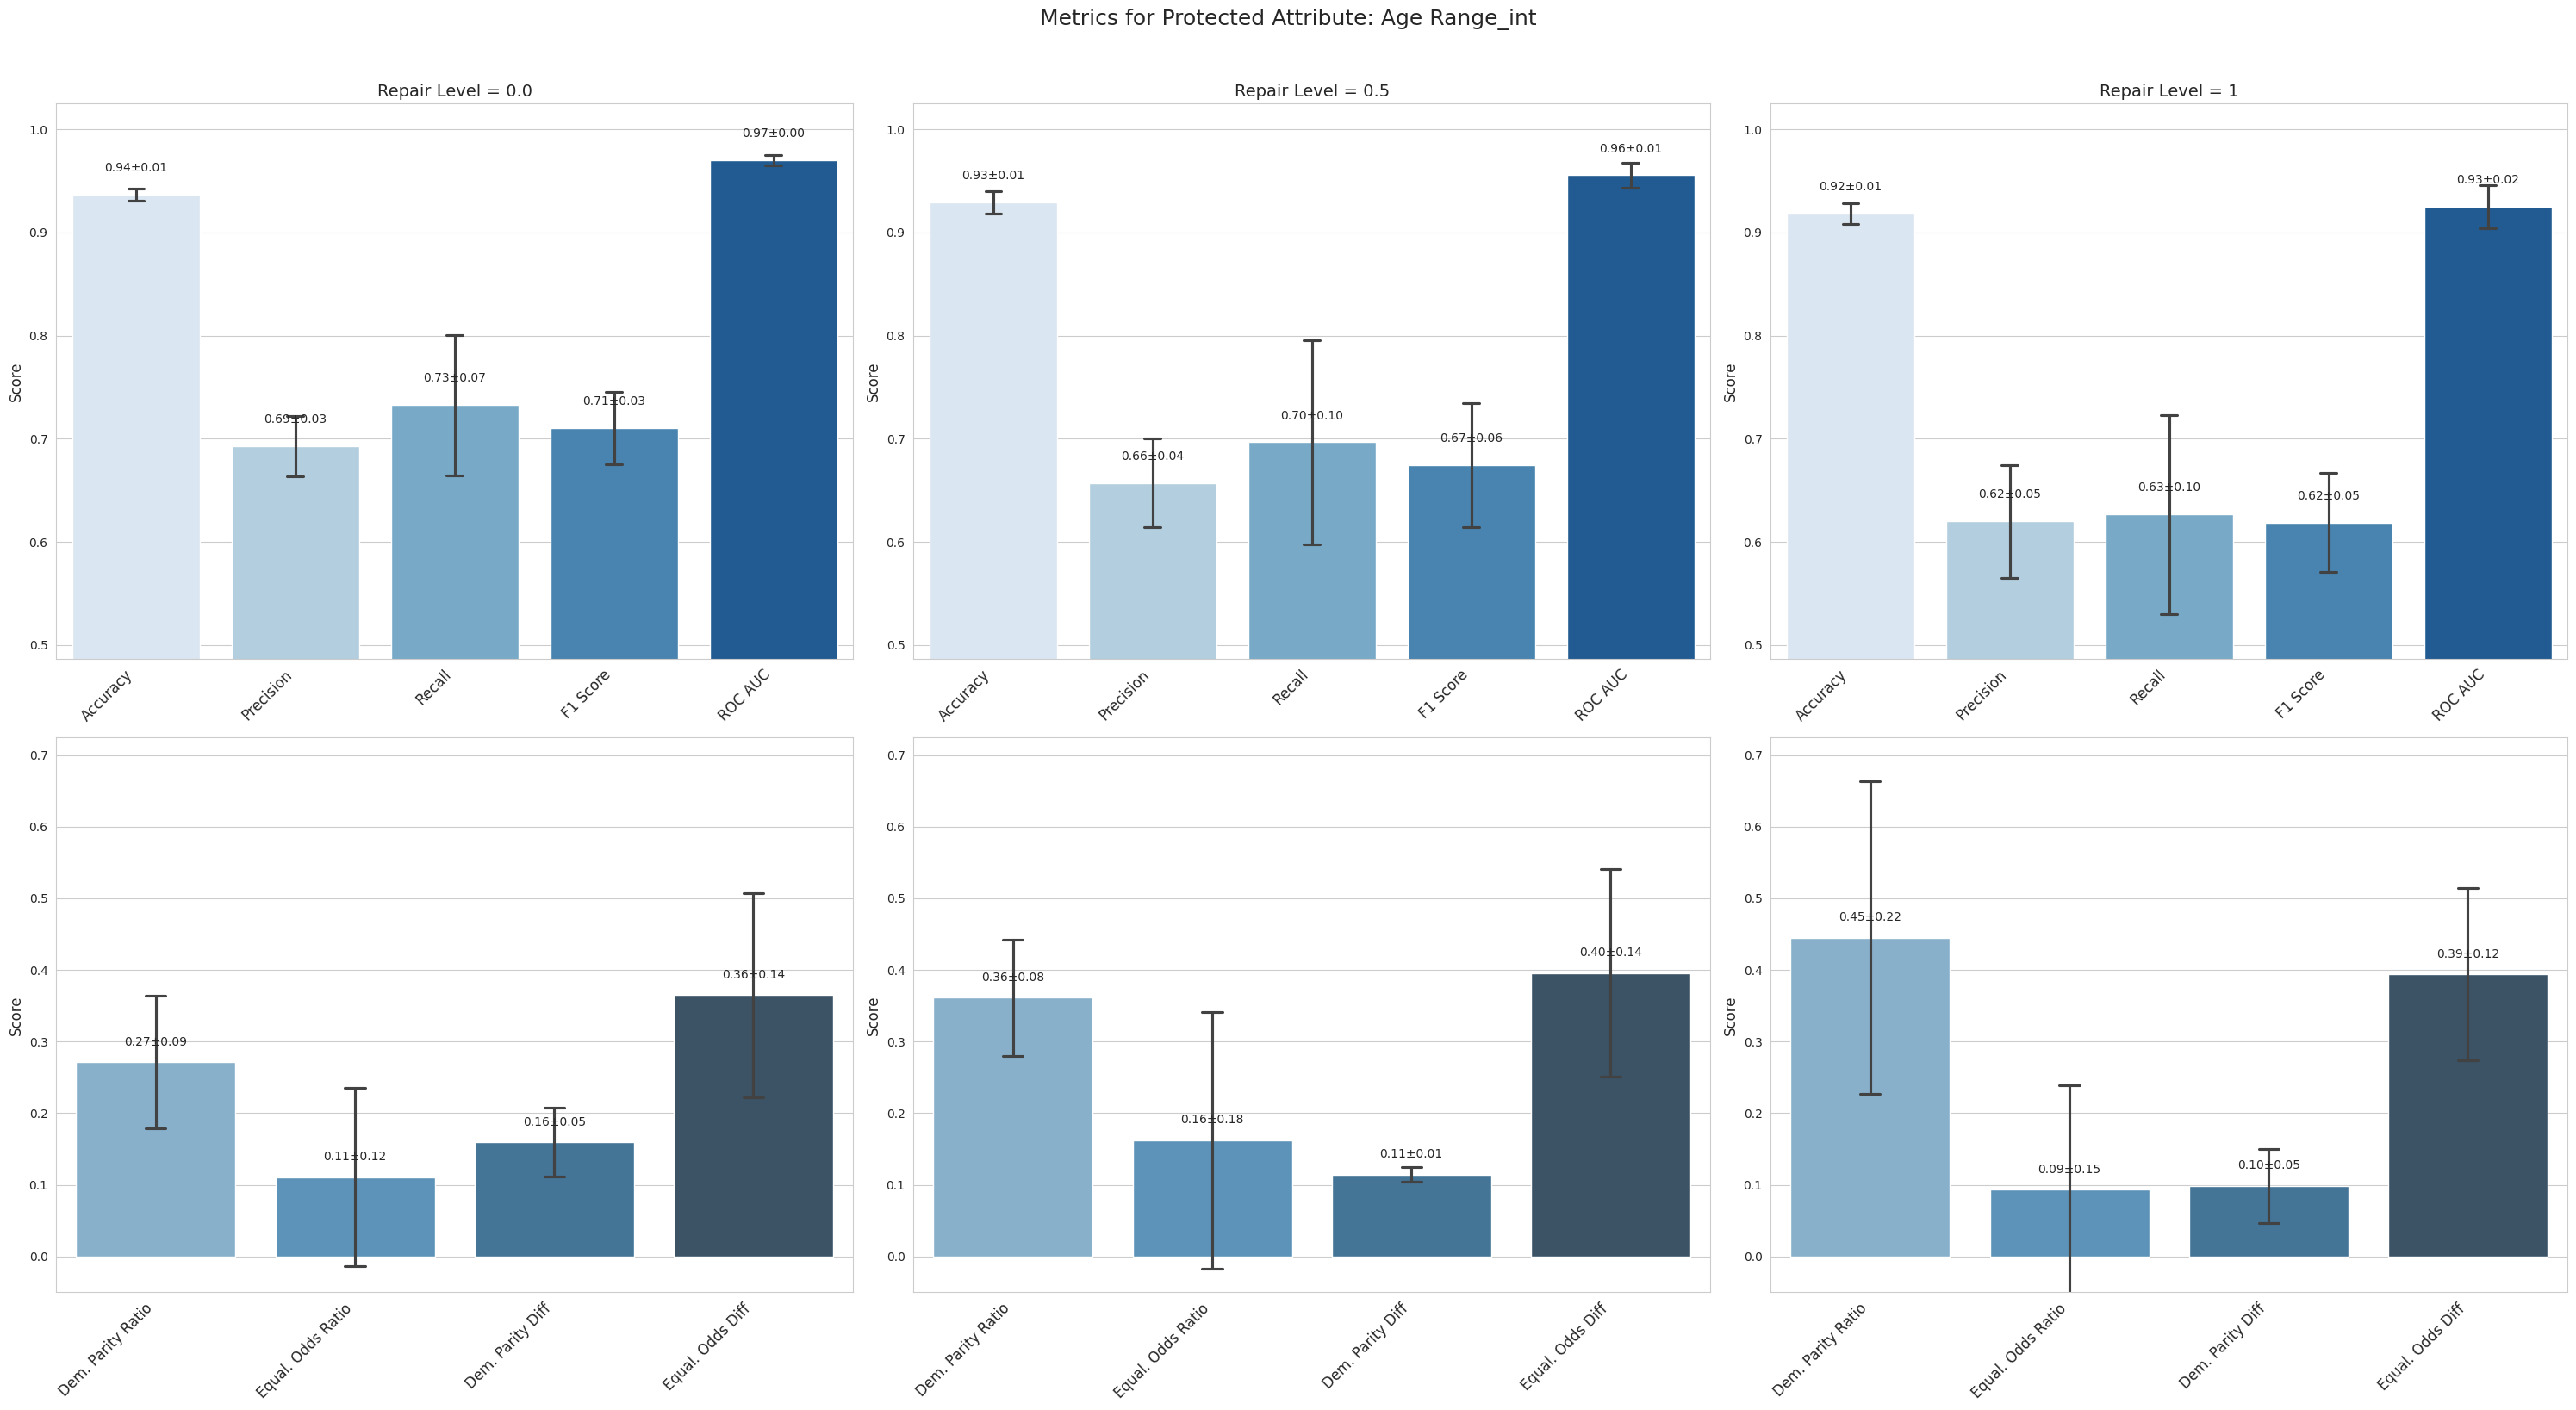

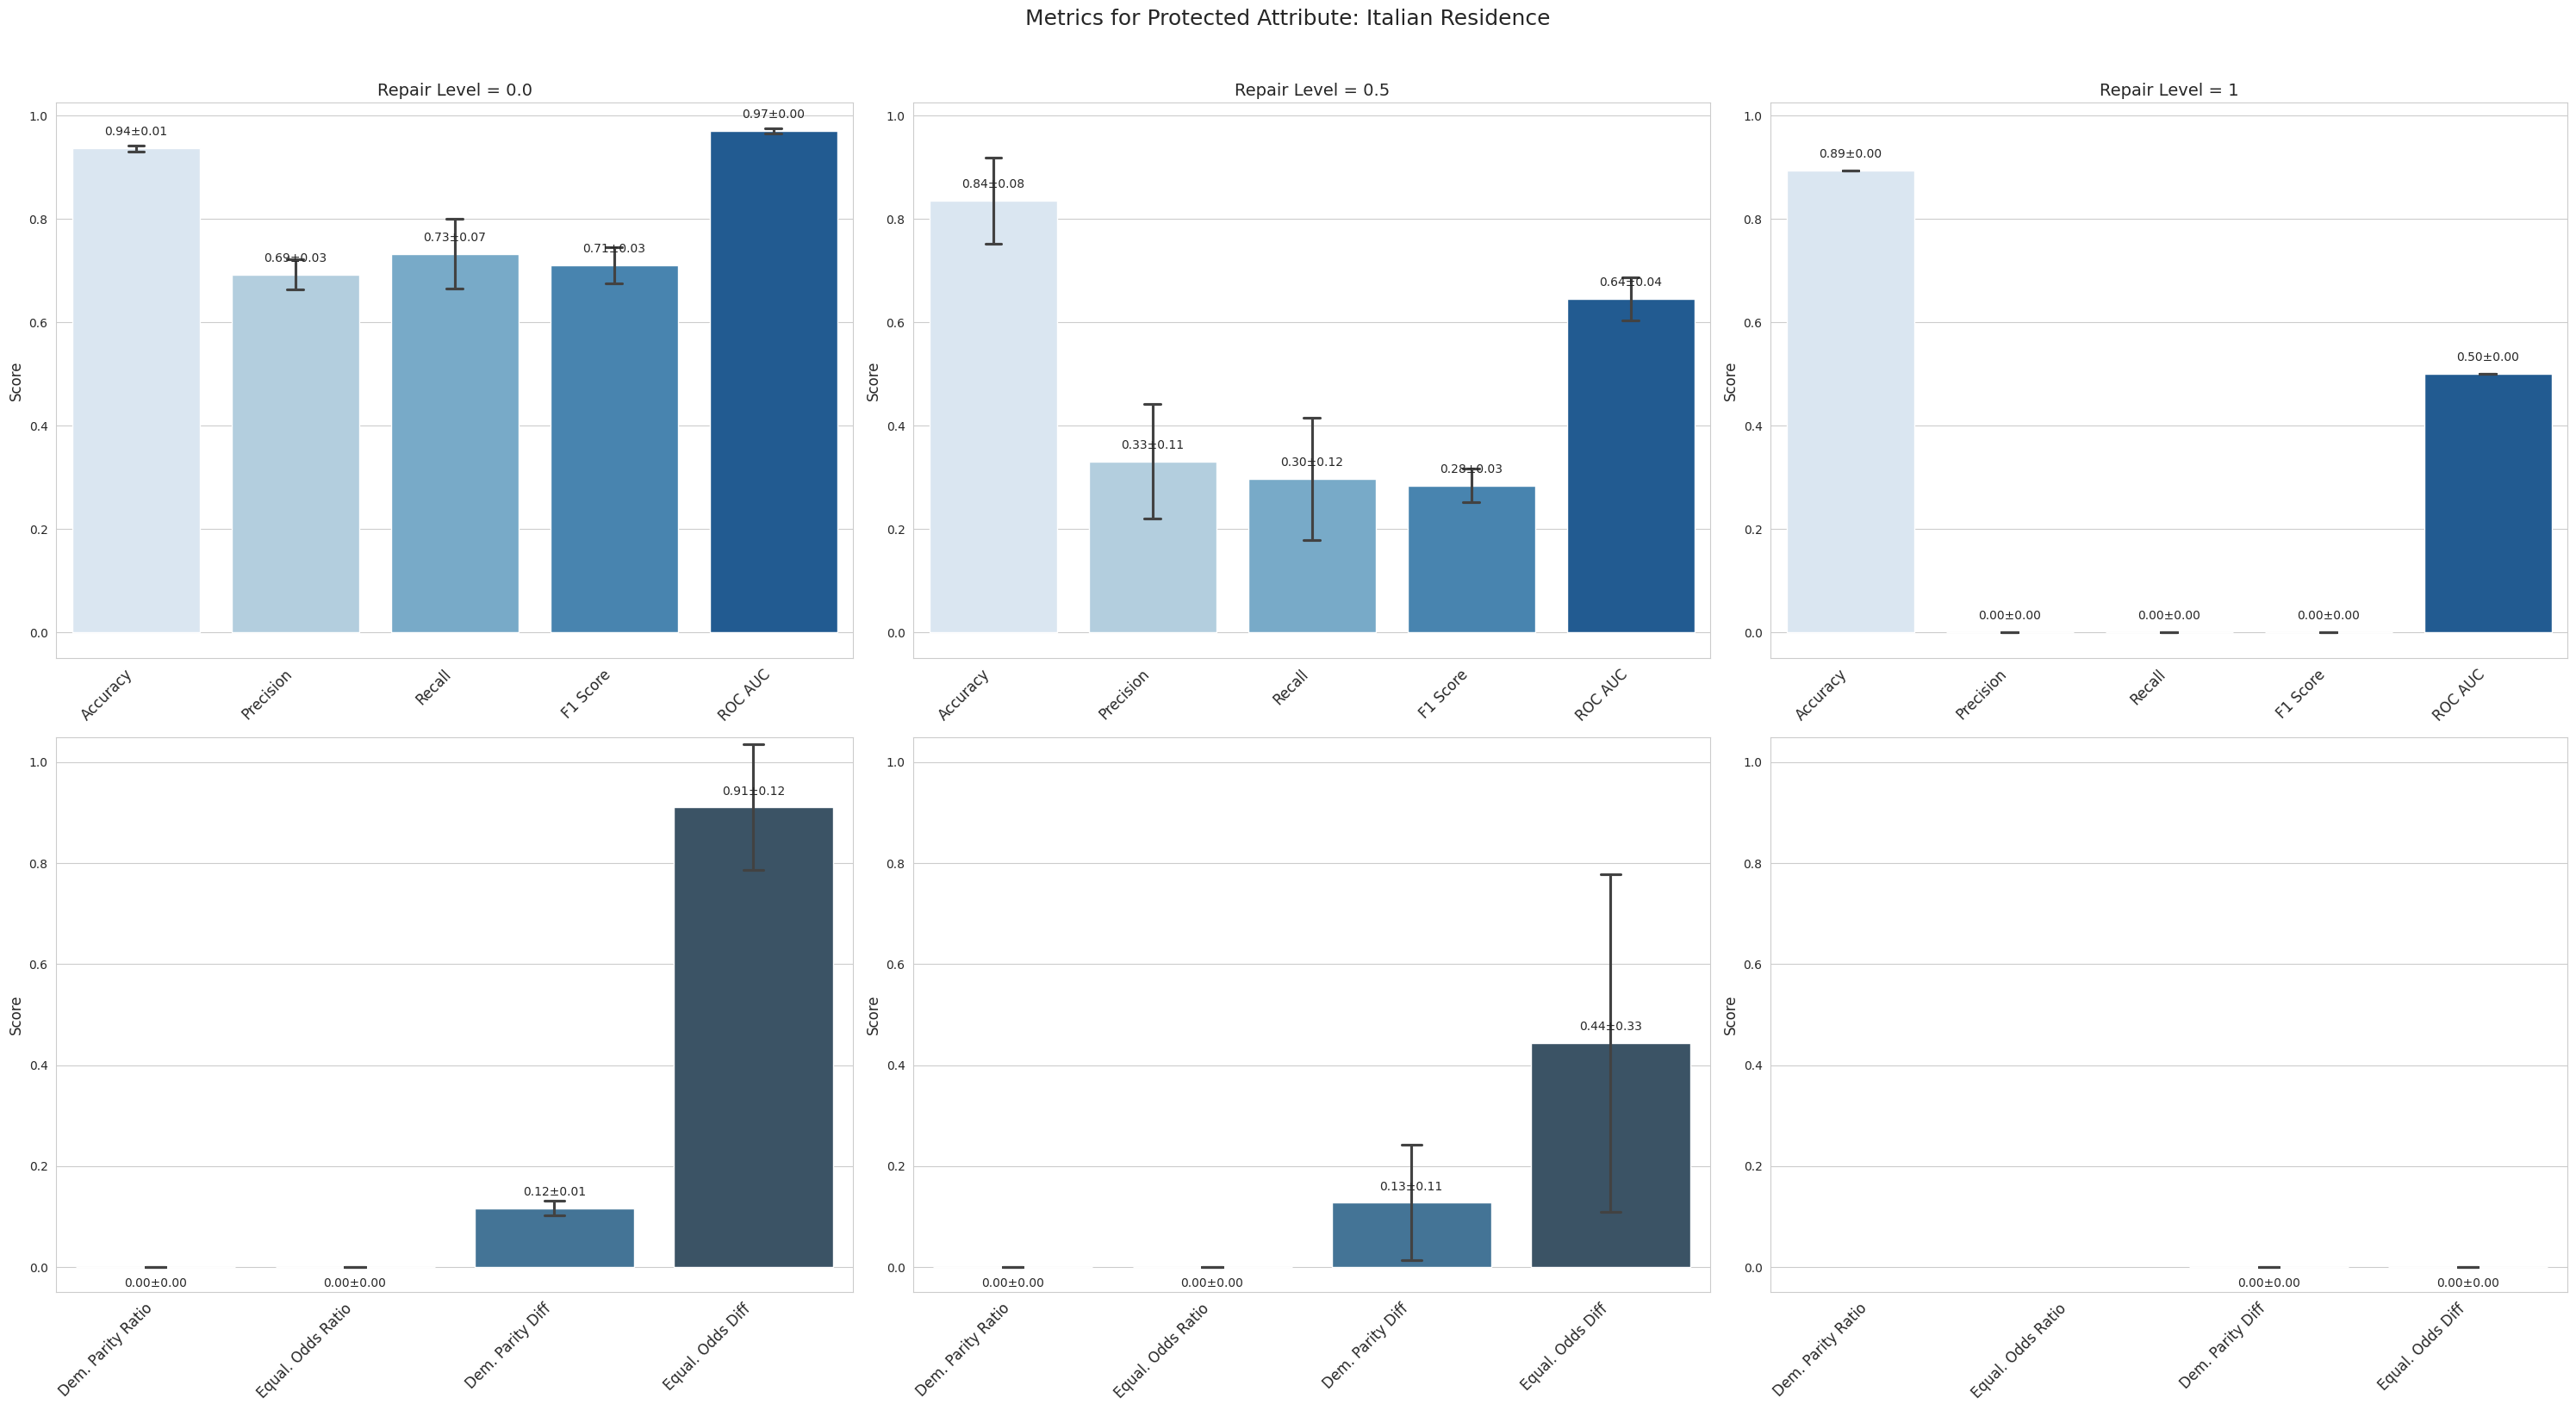

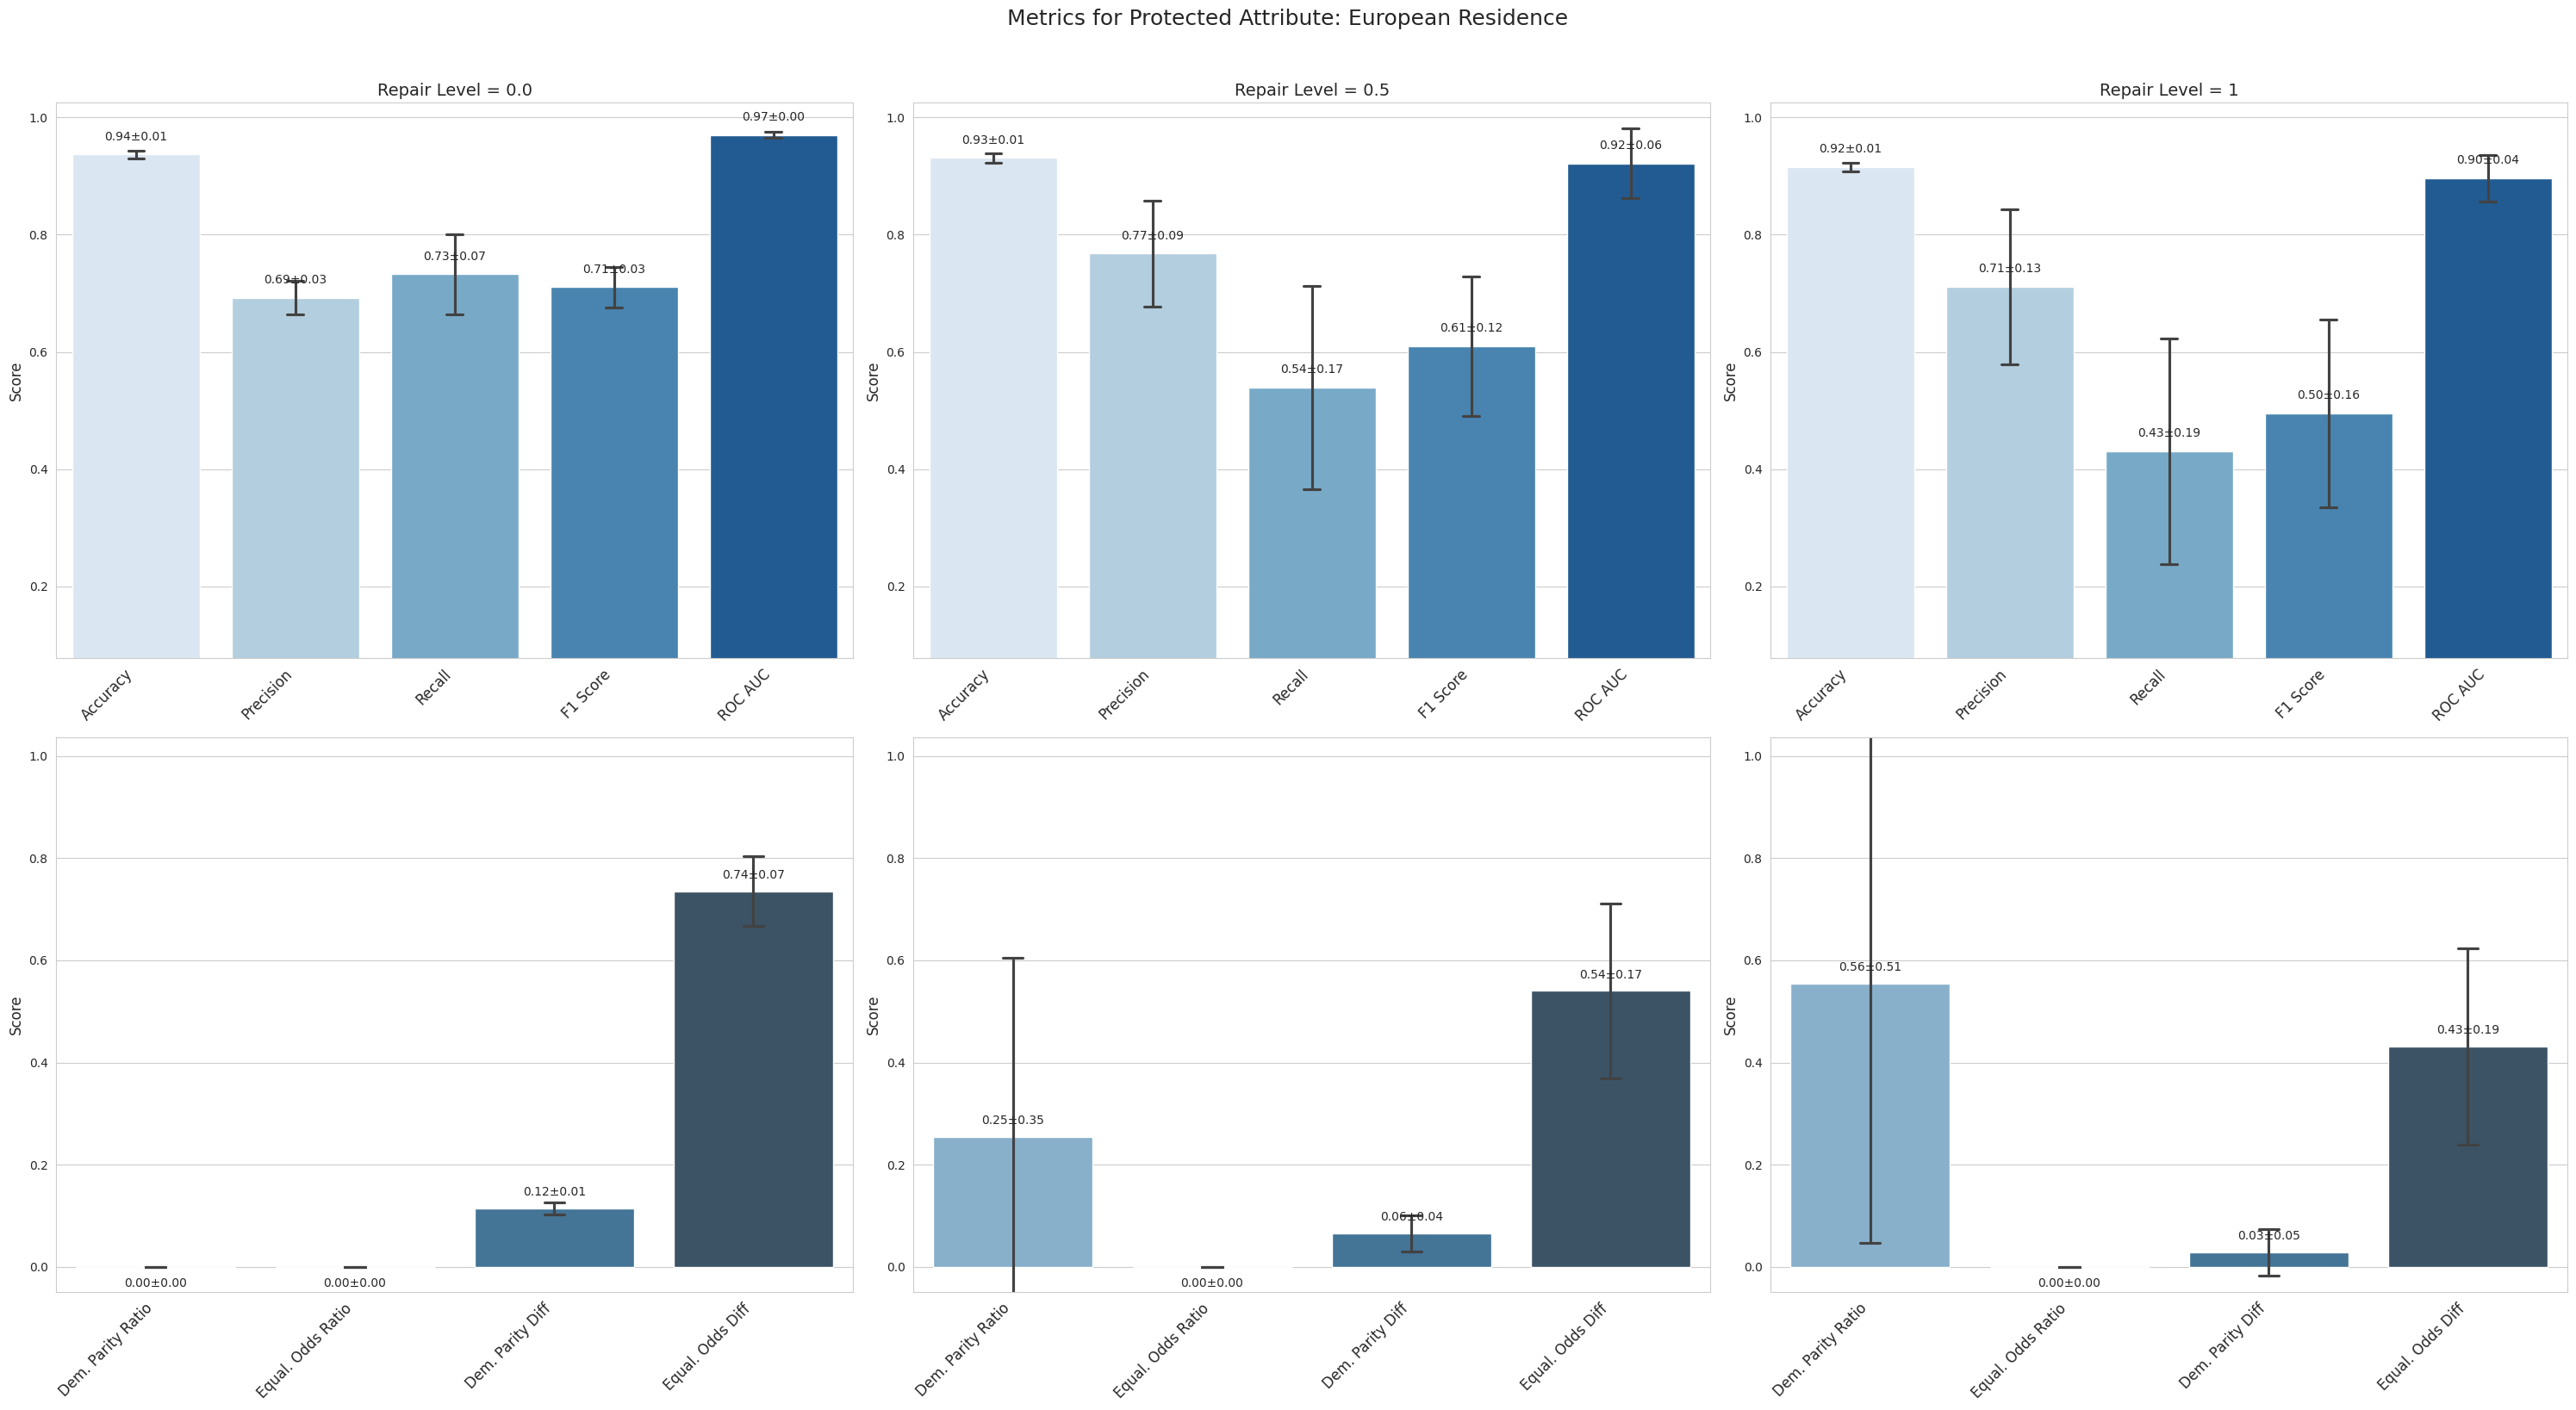

In [9]:
sns.set_style("whitegrid")
sns.set_palette("Blues")
rcParams['figure.figsize'] = (24, 16)

plot_metrics_grouped(results, protected_attributes, repair_levels)